In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import random

In [ ]:
BASE_DIR = "Dataset/Train/"
IMAGE_DIR = os.path.join(BASE_DIR, "images")
LABEL_DIR = os.path.join(BASE_DIR, "labels")

CLASS_NAMES = {
    0: "sunglass", 1: "hat", 2: "jacket", 3: "shirt", 4: "pants",
    5: "shorts", 6: "skirt", 7: "dress", 8: "bag", 9: "shoe"
}



In [32]:
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    annotations = []
    for line in lines:
        cls, cx, cy, w, h = map(float, line.strip().split())
        annotations.append({
            'class_id': int(cls),
            'center_x': cx,
            'center_y': cy,
            'width': w,
            'height': h
        })
    return annotations

def plot_image_with_boxes(image_path, annotations):
    img = cv2.imread(image_path)
    if img is None:
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    fig, ax = plt.subplots()
    ax.imshow(img)

    for ann in annotations:
        cx = ann['center_x'] * w
        cy = ann['center_y'] * h
        bw = ann['width'] * w
        bh = ann['height'] * h
        x0 = cx - bw / 2
        y0 = cy - bh / 2
        rect = plt.Rectangle((x0, y0), bw, bh, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        class_name = CLASS_NAMES.get(ann['class_id'], str(ann['class_id']))
        ax.text(x0, y0 - 5, class_name, color='white', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))
    ax.axis('off')
    plt.show()

## Alle afbeeldingen en labels samen

In [40]:
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith((".jpg", ".png", ".jpeg"))])


records = []

print("Labels laden...")
for img_file in tqdm(image_files):
    img_path = os.path.join(IMAGE_DIR, img_file)
    label_path = os.path.join(LABEL_DIR, os.path.splitext(img_file)[0] + ".txt")
    if not os.path.exists(label_path):
        continue
    annotations = load_annotations(label_path)
    for ann in annotations:
        ann["image"] = img_file
        records.append(ann)

df = pd.DataFrame(records)
df.head()

Labels laden...


100%|██████████| 2145/2145 [00:00<00:00, 2382.00it/s]


,class_id,center_x,center_y,width,height,image
0,8,0.68875,0.639167,0.3025,0.118333,1.jpg
1,7,0.65000,0.429167,0.4150,0.411667,1.jpg
2,9,0.61000,0.900833,0.1450,0.118333,1.jpg
3,3,0.56875,0.257500,0.3275,0.175000,100034.jpg
4,8,0.70625,0.480833,0.2125,0.188333,100034.jpg


## Klasseverdeling

C:\Users\srlam\AppData\Local\Temp\ipykernel_6564\2555052029.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="class_id", palette="Set2")


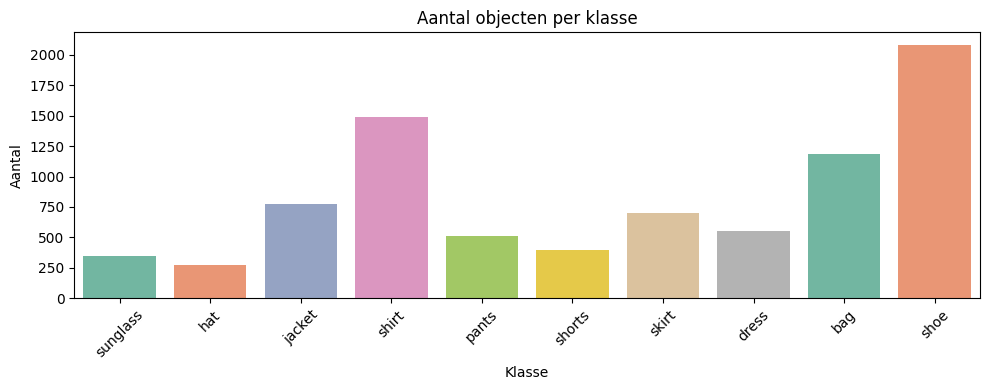

In [41]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="class_id", palette="Set2")
plt.title("Aantal objecten per klasse")
plt.xticks(ticks=range(10), labels=[CLASS_NAMES[i] for i in range(10)], rotation=45)
plt.xlabel("Klasse")
plt.ylabel("Aantal")
plt.tight_layout()
plt.show()

## Voorbeeld afbeeldingen

5 voorbeeldafbeeldingen met bounding-boxes:


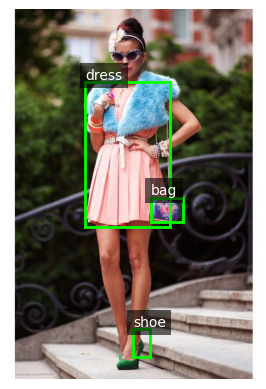

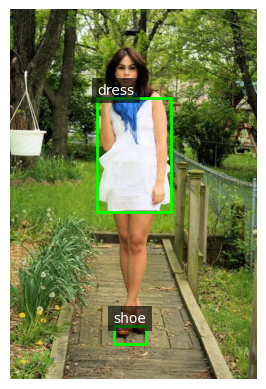

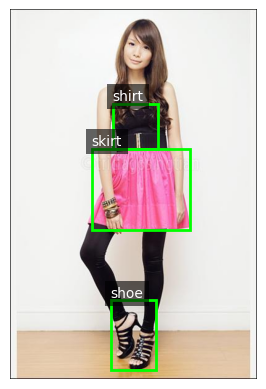

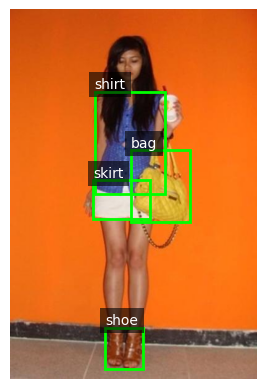

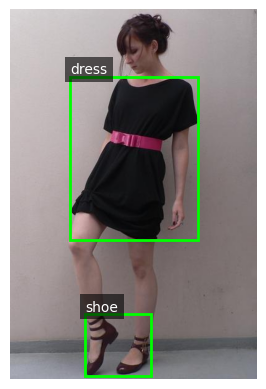

In [42]:
N_VIS = 5  # Aantal afbeeldingen om te visualiseren

print(f"{N_VIS} voorbeeldafbeeldingen met bounding-boxes:")
for fname in random.sample(image_files, k=min(N_VIS, len(image_files))):
    label_path = os.path.join(LABEL_DIR, os.path.splitext(fname)[0] + ".txt")
    anns = load_annotations(label_path)
    plot_image_with_boxes(os.path.join(IMAGE_DIR, fname), anns)

## Co-occurrence matrix (welke items komen samen in één afbeelding)

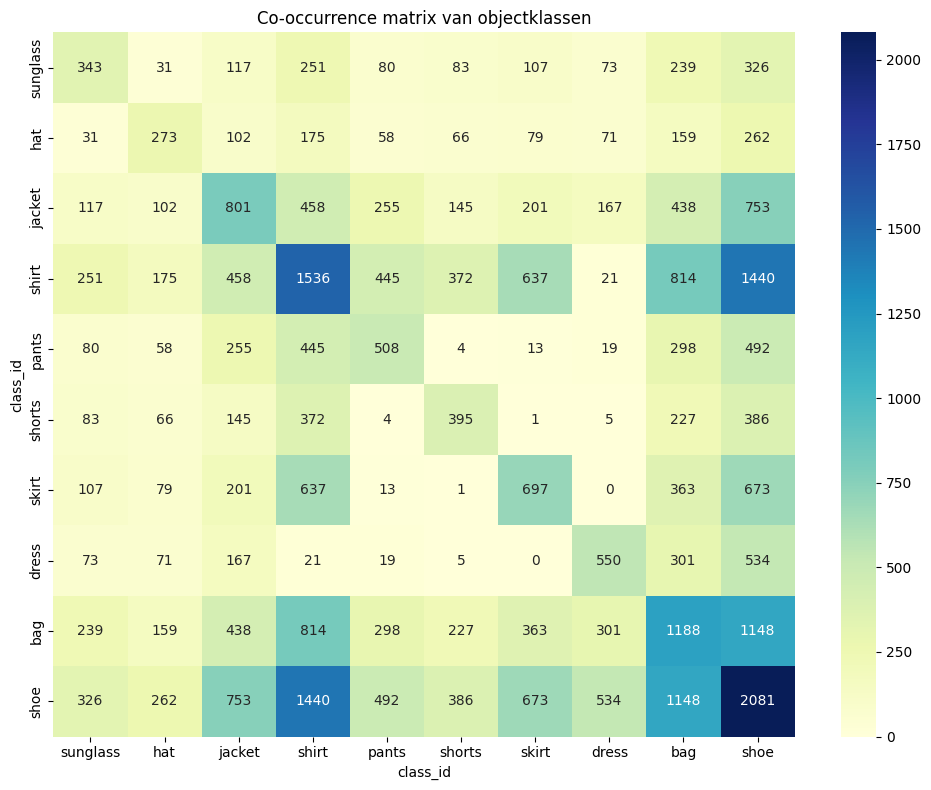

In [50]:
# Create a binary matrix: rows = images, columns = classes
pivot_df = df.pivot_table(index="image", columns="class_id", aggfunc="size", fill_value=0)
co_matrix = (pivot_df.T @ pivot_df)

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=[CLASS_NAMES[i] for i in range(10)],
            yticklabels=[CLASS_NAMES[i] for i in range(10)])
plt.title("Co-occurrence matrix van objectklassen")
plt.tight_layout()
plt.show()

## Aantal objecten per afbeelding

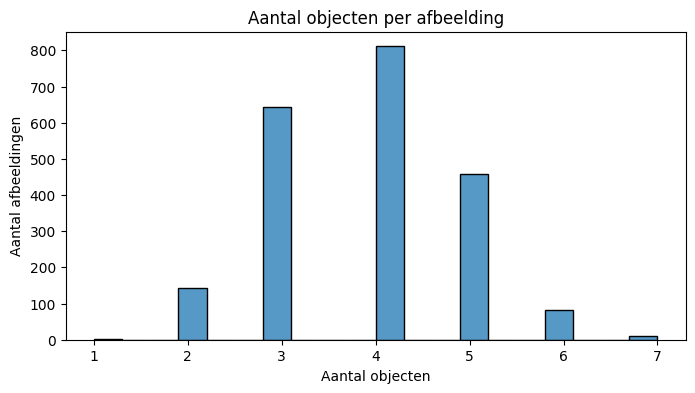

In [51]:
object_counts = df.groupby("image").size()

plt.figure(figsize=(8, 4))
sns.histplot(object_counts, bins=20)
plt.title("Aantal objecten per afbeelding")
plt.xlabel("Aantal objecten")
plt.ylabel("Aantal afbeeldingen")
plt.show()

## Overeenkomende items in captioning-dataset en de objectdetectiedatase

- De objectdetectie-dataset bevat 10 klassen:
0 = sunglass
1 = hat
2 = jacket
3 = shirt
4 = pants
5 = shorts
6 = skirt
7 = dress
8 = bag
9 = shoe

- De captioning dataset bevat Engels tekstuele bijschriften van kledingstukken. Veelvoorkomende begrippen in die bijschriften zijn:
“dress”
“jacket”
“skirt”
“shirt”
“pants”
“shorts”
“shoes”
“bag”
“hat”
“sunglasses”

Conclusie: alle 10 klassen van de objectdetectie-dataset komen ook voor als modetermen in de captioning-dataset. Ze zijn dus volledig overlappend en compatibel voor multimodale taken zoals bijschriften genereren per gedetecteerd object.

## Belangrijkste bevindingen van de EDA

- **Klasseverdeling:** Alle 10 objectklassen (zoals 'sunglass', 'hat', 'jacket', etc.) zijn goed vertegenwoordigd in de dataset, maar sommige klassen komen vaker voor dan andere. Vooral 'shirt', 'shoe' en 'jacket' zijn veelvoorkomend.

- **Aantal objecten per afbeelding:** De meeste afbeeldingen bevatten tussen de 2 en 5 objecten, met enkele uitschieters naar boven.

- **Co-occurrence matrix:** Bepaalde kledingstukken komen vaak samen voor in één afbeelding, bijvoorbeeld 'shirt' met 'pants' of 'shoe' met 'dress'. Dit wijst op realistische combinaties van kledingstukken.

- **Voorbeeldafbeeldingen:** De bounding boxes zijn over het algemeen goed geplaatst en de annotaties zijn visueel controleerbaar.

- **Overlap met captioning-dataset:** Alle objectklassen uit de objectdetectie-dataset komen ook als termen voor in de captioning-dataset. Dit maakt de datasets volledig compatibel voor multimodale taken.